<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/exempler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install scikit-learn==1.6.1
!pip install avalanche-lib

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [ ]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.nn.functional import cross_entropy
from torch.utils.data import Subset, ConcatDataset
import sklearn
from avalanche.benchmarks import RotatedMNIST, PermutedMNIST
from itertools import islice

In [ ]:
print('Important Library Version')
print('sklearn', sklearn.__version__)
print('pytorch', torch.__version__)
print('numpy', np.__version__)

Important Library Version
sklearn 1.6.1
pytorch 2.6.0+cu124
numpy 2.0.2


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import random

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  # 確保 CuDNN 使用確定性算法
torch.backends.cudnn.benchmark = False  # 禁止自適應選擇最佳內核，確保結果可重現
torch.set_float32_matmul_precision('high')

torch_gen = torch.Generator()
torch_gen.manual_seed(seed)

In [ ]:
batch_size = 256
epochs = 10
task = 10

In [ ]:
avalanche_list = [0, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051, 60000]

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [ ]:
benchmark = PermutedMNIST( # RotatedMNIST, PermutedMNIST
    n_experiences=task,
    seed=seed,
    # rotations_list=[0, 45, 90],
    # train_transform=Compose([Normalize(mean=[0.0], std=[1])]),
    # eval_transform=Compose([Normalize(mean=[0.0], std=[1])]),
)
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

## Data

In [ ]:
class SortedMNIST(Dataset):
  def __init__(self, task_num=None, train_stream=None, test_stream=None, train=True):
    super().__init__()
    if task_num == None or train_stream == None or test_stream == None:
        raise ValueError('Can\'t be None!')
    if train:
        self.data = [img for img, y, t in train_stream[task_num].dataset]
        self.target = [y for img, y, t in train_stream[task_num].dataset]
    else:
        self.data = [img for img, y, t in test_stream[task_num].dataset]
        self.target = [y for img, y, t in test_stream[task_num].dataset]
    self.data = np.array(self.data)
    self.target = np.array(self.target)
    '''
    sorted_idx = np.argsort(self.target)
    self.data = self.data[sorted_idx]
    self.target = self.target[sorted_idx]
    '''
    self.data = torch.from_numpy(self.data)
    self.target = torch.from_numpy(self.target)
  def __getitem__(self, index):
    return self.data[index], self.target[index]
  def __len__(self):
    return len(self.data)

In [ ]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

# test_task_1 = SortedMNIST(task_num=0, train_stream=train_stream, test_stream=test_stream, train=False)
# test_task_2 = SortedMNIST(task_num=1, train_stream=train_stream, test_stream=test_stream, train=False)

# task_1_loader = DataLoader(test_task_1, batch_size=128, pin_memory=True, generator=torch_gen)
# task_2_loader = DataLoader(test_task_2, batch_size=128, pin_memory=True, generator=torch_gen)

test_task = []
task_loader = []
for i in range(task):
    data = SortedMNIST(task_num=i, train_stream=train_stream, test_stream=test_stream, train=False)
    test_task.append(data)

    loader = DataLoader(test_task[-1], batch_size=128, pin_memory=True, generator=torch_gen)
    task_loader.append(loader)

## Model

In [ ]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        '''
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.dense = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )
        '''
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            # nn.Linear(400, 400),
            # nn.ReLU(),
        )
        self.linear = nn.Linear(512, 10)
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        X = self.net(X)
        return X, self.linear(X)

In [ ]:
# from torchsummary import summary
# summary(model, (1, 28, 28))

In [ ]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            _, output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')
    return test_acc / num_data # return accuracy for calculate ACC, BWT

## Fisher
 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [ ]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 1e-6

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, generator=torch_gen)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # idx = 0
    # bound = ((60000//batch_size)*1)//1
    # record_label = np.array([], dtype=int)
    # print('Bound is', bound, 'times')
    # Calculate Fisher Matrix
    for data in train_loader:
        # if idx == bound: break
        # else: idx += 1

        img, label = data
        img, label = img.to(device), label.to(device).long()

        # flag
        # record_label = np.append(record_label, label.cpu().numpy())
        _, output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)
    # print('Number of Digits after Sampling', np.bincount(record_label)) # flag
    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader) #idx

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

## Exempler

In [ ]:
def get_confid_and_outcome(dataloader, model):
  global device
  confidence = torch.tensor([], dtype=torch.float32, device=device)
  prediction = torch.tensor([], dtype=bool, device=device)
  encode = None

  model.eval()
  with torch.no_grad():
    for data in dataloader:
      img, label = data
      img, label = img.to(device), label.to(device).long()
      e, output = model(img)

      conf, pred = output.max(axis=1)
      confidence = torch.cat((confidence, conf))

      pred = pred == label
      prediction = torch.cat((prediction, pred))

      if encode is None:
          encode = e
      else:
          encode = torch.cat((encode, e))

  return confidence, prediction, encode

In [ ]:
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, DBSCAN

In [ ]:
def remove_outlier(reduce, data):
    eps = 1
    last_perc = -1
    while True:
        dbscan = DBSCAN(eps=eps, min_samples=10)
        dbscan.fit(reduce)
        outlier = dbscan.labels_ == -1

        percentage = 1 - outlier.sum()/len(data)
        percentage = round(percentage, 4)
        upper_bound = 0.99
        lower_bound = 0.98
        if last_perc != round(percentage, 2): # 弄一下，不然太多訊息了OAO
            print('\033[38;5;249m' + 'Select outlier', outlier.sum(), f', {outlier.sum()}/{len(data)}({1 - percentage:.4f})' + '\033[0m')
        last_perc = round(percentage, 2)

        if upper_bound >= percentage >= lower_bound: break
        elif percentage > upper_bound: eps -= (percentage - upper_bound) / (1 - upper_bound)
        elif percentage < lower_bound: eps += (lower_bound - percentage) / lower_bound

    print()
    return torch.from_numpy(outlier)


In [ ]:
def get_center(sub_dataset, num_exempler, encode=None):
  if encode is None:
      data = np.array([sub_dataset[i][0].numpy() for i in range(len(sub_dataset))], dtype=np.float32)# sub_dataset.dataset.data
      data = torch.from_numpy(data)
      data = data.reshape(len(data), -1) # 2D
      # print(data.shape)
  else: data = encode

  reduced_dim = int(data.shape[1] * (0.5 if encode is None else 1))
  reduce = PCA(reduced_dim, random_state=seed).fit_transform(data)
  # reduce = NMF(reduced_dim, random_state=seed, max_iter=3000).fit_transform(data)

  # outlier = remove_outlier(reduce, data)
  remove_outlier_idx = torch.arange(reduce.shape[0])
  # remove_outlier_idx = torch.where(outlier == False)[0]

  kmean = KMeans(num_exempler, random_state=seed, n_init=10)
  kmean_outcome = kmean.fit_transform(reduce[remove_outlier_idx])
  print('\033[38;5;243m' + f'after PCA Dim: {reduced_dim}({reduced_dim/data.shape[1]:.2f}), Inertia: {kmean.inertia_:.4f}' + '\033[0m')

  centers = kmean.cluster_centers_
  idx = torch.tensor([], dtype=int, device=device)
  for c in centers:
    min_dis = 1e9
    min_idx = -1
    for i in remove_outlier_idx:
      point = reduce[i]
      dis = np.linalg.norm(c - point, ord=2)
      if min_dis > dis:
        min_dis = dis; min_idx = i
    idx = torch.cat((idx, torch.tensor([min_idx], dtype=int, device=device)))
  idx, _ = torch.sort(idx)
  return sub_dataset.indices[idx]

In [ ]:
def select_exempler(dataset, model, num_exempler=10, lower_bound_confid=0.9, avalanche_list=[]):
  now_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, generator=torch_gen)
  confidence, pred, encode = get_confid_and_outcome(now_loader, model)
  del now_loader

  selected_idx = torch.where(torch.logical_and(confidence >= lower_bound_confid, pred))[0]
  exempler = torch.tensor([], dtype=int, device=device)

  for i in range(10):
    condition = torch.logical_and(avalanche_list[i] <= selected_idx, selected_idx < avalanche_list[i + 1])
    sub_select = selected_idx[condition]
    print('Select', len(sub_select))
    sub_class = Subset(dataset, sub_select)

    center = get_center(sub_class, num_exempler, encode=encode[sub_select].cpu()) # encode[sub_select]
    exempler = torch.cat((exempler, center))
  return exempler

In [ ]:
def random_select(dataset, mode=0, num_exempler=10, avalanche_list=[]):
  num_instance = len(dataset)
  if mode == 0:
    return torch.from_numpy(np.random.choice(torch.arange(num_instance), num_exempler * 10))
  else:
    select = torch.tensor([], dtype=int, device=device)
    for i in range(10):
      pre_class = np.random.choice(np.arange(avalanche_list[i], avalanche_list[i+1]), num_exempler)
      select = torch.cat((select, torch.from_numpy(pre_class).to(device)))
    return select

In [ ]:
record_exempler = []

## training

In [ ]:
record_acc = np.zeros((task, task))

In [ ]:
blue = '\033[34m'
null = '\033[0m'

In [ ]:
def kl_divergence(data, eps=1e-8):
    var = torch.var(data, dim=tuple(range(1, data.ndim)), unbiased=False)
    mean = torch.mean(data, dim=tuple(range(1, data.ndim)))

    kl = 0.5 * (var.sum(dim=-1) + mean.pow(2).sum(dim=-1) - var.size(-1) - torch.log(var + eps).sum(dim=-1))
    return kl

In [ ]:
def training(model, test_loader: list, test_num: list, epochs=10,
             num_task=-1, avalanche_list=[], num_exempler=100, alpha=0):
    """
    改進的訓練函數，更好地模擬ReplayDataLoader的平衡採樣策略
    """
    if num_task < 0:
        raise ValueError("Task Number is Missing")

    global optim_para, fisher_matrix, ewc_lambda, record_acc, record_exempler
    # 保持EWC lambda=1

    print(f'Task {num_task} Start!')

    # 準備當前任務的數據
    train_data = SortedMNIST(train=True, task_num=num_task, train_stream=train_stream, test_stream=test_stream)

    # 計算每個任務的樣本數量
    current_samples = len(train_data)
    memory_samples = sum(len(exempler) for exempler in record_exempler)

    print(f'Current Task Samples: {current_samples}, Memory Samples: {memory_samples}, alpha: {alpha}')

    # 為模型訓練準備數據加載器
    if not record_exempler:  # 第一個任務，沒有記憶樣本
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                 pin_memory=True, generator=torch_gen)
    else:
        # 正確實現ReplayDataLoader的核心思想 - 任務平衡採樣
        train_loader = create_true_replay_dataloader(train_data, record_exempler, batch_size)

    # 使用與原始代碼相同的優化器設置
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        samples_seen = 0

        for data_batch in train_loader:
            optimizer.zero_grad()

            # 解包數據和標籤
            img, label = data_batch
            img, label = img.to(device), label.to(device).long()

            # 前向傳播
            encode, output = model(img)
            output_loss = cross_entropy(output, label)

            # 計算準確率
            train_acc += (output.argmax(1) == label).sum().item()
            samples_seen += len(label)

            # 添加EWC損失 - 保持原始實現
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda

            kl_loss = kl_divergence(encode)

            # 總損失
            output_loss += alpha * kl_loss
            output_loss += ewc_loss
            train_loss += output_loss.item()

            # 反向傳播
            output_loss.backward()
            optimizer.step()

        # 輸出訓練信息
        avg_acc = train_acc / samples_seen
        avg_loss = train_loss / len(train_loader)
        print(f'Epoch\t{i + 1}\tAcc: {avg_acc:.4f}, Loss: {avg_loss:.4f}, use sample: {samples_seen}')

    # 如果不是最後一個任務，更新參數記錄並選擇樣本
    if num_task != len(test_num) - 1:
        # 記錄最優參數和Fisher信息
        record_parameter(model, train_data, optimizer, num_task=num_task)

        with torch.no_grad():
            # 使用原始的exempler選擇方法
            exempler = select_exempler(train_data, model, num_exempler, avalanche_list=avalanche_list)
            # exempler = random_select(train_data, mode=1, num_exempler=num_exempler, avalanche_list=avalanche_list)
            record_exempler.append(Subset(train_data, exempler))

    # 在所有任務上評估模型
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        acc = evaluate(model, loader, num_data, task_id)
        record_acc[num_task, task_id] = acc
        task_id = task_id + 1

    print()  # End of Training


In [ ]:
def create_true_replay_dataloader(current_data, memory_data_list, batch_size):
    """
    創建一個真正按照ReplayDataLoader核心思想實現的數據加載器

    ReplayDataLoader的核心思想是:
    1. 同時從當前任務和所有記憶任務中採樣
    2. 確保每個任務的樣本數量平衡
    3. 保持每個批次的總大小不變
    """
    # 計算任務數量
    num_tasks = 1 + len(memory_data_list)  # 當前任務 + 記憶任務

    # 平均分配批次大小給每個任務
    samples_per_task = batch_size // num_tasks

    # 剩餘樣本優先分配給當前任務
    remaining_samples = batch_size - (samples_per_task * num_tasks)

    # 當前任務分配的樣本數
    current_task_samples = samples_per_task + remaining_samples

    # 創建數據集列表
    datasets = [current_data] + memory_data_list

    # 創建一個類似ReplayDataLoader的自定義數據加載器
    class TaskBalancedDataLoader:
        def __init__(self, datasets, samples_per_dataset, batch_size):
            self.datasets = datasets
            self.samples_per_dataset = samples_per_dataset  # 列表，每個任務的樣本數
            self.batch_size = batch_size
            self.current_data_len = len(datasets[0])

            # 計算每個epoch的批次數量 - 基於當前數據集的大小
            self.num_batches = self.current_data_len // self.samples_per_dataset[0]
            if self.current_data_len % self.samples_per_dataset[0] > 0:
                self.num_batches += 1

        def __iter__(self):
            # 為每個數據集創建一個迭代器
            iterators = []
            for i, dataset in enumerate(self.datasets):
                # 計算需要的樣本總數
                num_samples = self.samples_per_dataset[i] * self.num_batches

                # 創建一個隨機採樣器
                indices = torch.randperm(len(dataset)).tolist()

                # 如果需要的樣本數大於數據集大小，則循環使用
                if num_samples > len(dataset):
                    # 計算需要重複的次數
                    repeats = num_samples // len(dataset) + 1
                    indices = indices * repeats

                # 截取需要的樣本數
                indices = indices[:num_samples]

                # 創建一個對應的數據迭代器
                iterators.append(iter([dataset[i] for i in indices]))

            # 生成批次
            for _ in range(self.num_batches):
                batch_imgs = []
                batch_labels = []

                # 從每個任務採樣
                for i, iterator in enumerate(iterators):
                    for _ in range(self.samples_per_dataset[i]):
                        try:
                            img, label = next(iterator)
                            batch_imgs.append(img.unsqueeze(0))
                            batch_labels.append(label)
                        except StopIteration:
                            # 如果迭代器耗盡，重新創建
                            iterators[i] = iter([self.datasets[i][j] for j in
                                             torch.randperm(len(self.datasets[i])).tolist()])
                            img, label = next(iterators[i])
                            batch_imgs.append(img.unsqueeze(0))
                            batch_labels.append(label)

                # 合併批次
                batch_imgs = torch.cat(batch_imgs, dim=0)
                batch_labels = torch.tensor(batch_labels)

                # 隨機打亂批次內的順序
                perm = torch.randperm(len(batch_labels))
                batch_imgs = batch_imgs[perm]
                batch_labels = batch_labels[perm]

                yield batch_imgs, batch_labels

        def __len__(self):
            return self.num_batches

    # 創建每個任務的樣本數量列表
    samples_per_dataset = [current_task_samples] + [samples_per_task] * len(memory_data_list)
    print(blue + 'samples_per_dataset' + str(samples_per_dataset) + null)
    # 創建並返回數據加載器
    return TaskBalancedDataLoader(datasets, samples_per_dataset, batch_size)

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [ ]:
model = Module().to(device)

for i in range(task):
    training(model, task_loader, [len(test_task[0])] * task,
             num_task=i, epochs=epochs,
            avalanche_list=avalanche_list, num_exempler=3, alpha=0)

Task 0 Start!
Current Task Samples: 60000, Memory Samples: 0, alpha: 0
Epoch	1	Acc: 0.4168, Loss: 2.0653, use sample: 60000
Epoch	2	Acc: 0.7227, Loss: 1.6209, use sample: 60000
Epoch	3	Acc: 0.7787, Loss: 1.2758, use sample: 60000
Epoch	4	Acc: 0.8116, Loss: 1.0349, use sample: 60000
Epoch	5	Acc: 0.8303, Loss: 0.8738, use sample: 60000
Epoch	6	Acc: 0.8428, Loss: 0.7649, use sample: 60000
Epoch	7	Acc: 0.8522, Loss: 0.6876, use sample: 60000
Epoch	8	Acc: 0.8589, Loss: 0.6306, use sample: 60000
Epoch	9	Acc: 0.8649, Loss: 0.5871, use sample: 60000
Epoch	10	Acc: 0.8694, Loss: 0.5526, use sample: 60000
Select 5619
after PCA Dim: 512(1.00), Inertia: 376156.9181
Select 6486
after PCA Dim: 512(1.00), Inertia: 141279.6568
Select 4945
after PCA Dim: 512(1.00), Inertia: 363414.5391
Select 5133
after PCA Dim: 512(1.00), Inertia: 325196.4262
Select 5119
after PCA Dim: 512(1.00), Inertia: 280672.5915
Select 4142
after PCA Dim: 512(1.00), Inertia: 265385.2788
Select 5469
after PCA Dim: 512(1.00), Inerti

## Calculate Outcome

In [ ]:
acc = 0
bwt = 0

for i in range(task):
    acc += record_acc[-1, i]
acc /= task

for i in range(task - 1):
    bwt += record_acc[-1, i] - record_acc[i, i]
bwt /= (task - 1)

print(f'ACC : {acc:.4f}')
print(f'BWT : {bwt:.4f}')

ACC : 0.8488
BWT : -0.0403


 - Task 0

Accuracy 0.7972
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       980
           1       0.90      0.93      0.92      1135
           2       0.73      0.81      0.77      1032
           3       0.74      0.87      0.80      1010
           4       0.89      0.58      0.70       982
           5       0.82      0.61      0.70       892
           6       0.77      0.93      0.84       958
           7       0.84      0.81      0.83      1028
           8       0.78      0.72      0.75       974
           9       0.71      0.76      0.73      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.80      0.79     10000



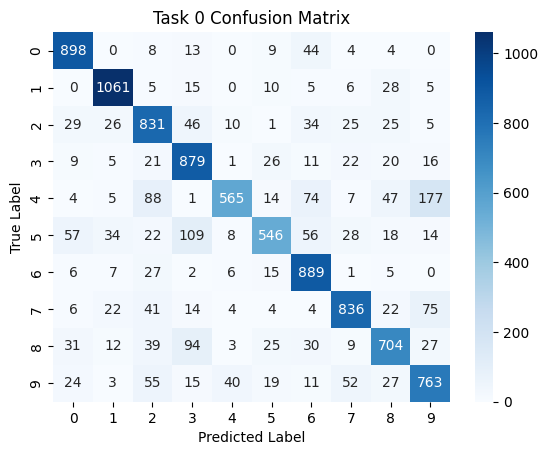

In [ ]:
true_label = []
pred_label = []
try:
    class_name = test_task_1.classes
except:
    class_name = [str(i) for i in  range(10)]

with torch.no_grad():
    for data in task_loader[0]:
        img, label = data
        img, label = img.to(device), label.to(device)
        _, output = model(img)
        output = output.argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=class_name),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

In [ ]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-05-14_07_08_05


In [ ]:
import pickle
with open('history.pickle', 'wb') as f:
  pickle.dump(record_acc, f)

In [ ]:
record_acc

array([[0.87839997, 0.0669    , 0.1513    , 0.1184    , 0.1601    ,
        0.13079999, 0.1523    , 0.09959999, 0.15629999, 0.1682    ],
       [0.85529995, 0.87799996, 0.21259999, 0.15889999, 0.1894    ,
        0.1752    , 0.2288    , 0.1727    , 0.1548    , 0.1646    ],
       [0.84309995, 0.86219996, 0.8779    , 0.183     , 0.16859999,
        0.1656    , 0.23559999, 0.18779999, 0.12789999, 0.1681    ],
       [0.8351    , 0.85539997, 0.87039995, 0.88379997, 0.1529    ,
        0.19749999, 0.2243    , 0.16149999, 0.14399999, 0.1435    ],
       [0.81979996, 0.85099995, 0.86079997, 0.87029999, 0.88549995,
        0.2067    , 0.20539999, 0.1399    , 0.1505    , 0.14219999],
       [0.8114    , 0.84539998, 0.85229999, 0.85999995, 0.8761    ,
        0.88349998, 0.22499999, 0.1276    , 0.14199999, 0.1111    ],
       [0.8046    , 0.83749998, 0.84359998, 0.8531    , 0.86930001,
        0.87180001, 0.88879997, 0.1212    , 0.1302    , 0.1107    ],
       [0.80379999, 0.83019996, 0.8424999